In [3]:
import logging
from dataclasses import asdict, dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from pprint import pformat
from copy import copy
import torch
import cv2
from contextlib import nullcontext
import numpy as np
from itertools import accumulate
import pandas as pd
#import roboticstoolbox as rtb

# from safetensors.torch import load_file, save_file
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.factory import make_policy
from lerobot.common.robot_devices.control_configs import (
    ControlPipelineConfig,
    EvalControlConfig,
)
from lerobot.common.utils.utils import init_logging, get_safe_torch_device
from lerobot.configs import parser

def predict_action(observation, policy, device, use_amp):
    observation = copy(observation)
    with (
        torch.inference_mode(),
        torch.autocast(device_type=device.type) if device.type == "cuda" and use_amp else nullcontext(),
    ):
        # Convert to pytorch format: channel first and float32 in [0,1] with batch dimension
        for name in observation:
            if "image" in name:
                observation[name] = observation[name].type(torch.float32) / 255
                observation[name] = observation[name].permute(2, 0, 1).contiguous()
            observation[name] = observation[name].unsqueeze(0)
            observation[name] = observation[name].to(device)

        # Compute the next action with the policy
        # based on the current observation
        action = policy.select_action(observation)

        # Remove batch dimensifrom dataclasses import asdict, dataclasson
        action = action.squeeze(0)

        # Move to cpu, if not already the case
        action = action.to("cpu")

    return action
def get_episode_data_index(
    episode_dicts: dict[dict], episodes: list[int] | None = None
) -> dict[str, torch.Tensor]:
    episode_lengths = {ep_idx: ep_dict["length"] for ep_idx, ep_dict in episode_dicts.items()}
    if episodes is not None:
        episode_lengths = {ep_idx: episode_lengths[ep_idx] for ep_idx in episodes}

    cumulative_lengths = list(accumulate(episode_lengths.values()))
    return {
        "from": torch.LongTensor([0] + cumulative_lengths[:-1]),
        "to": torch.LongTensor(cumulative_lengths),
    }

# Forward kinematics function
def forward_kinematics(joint_angles,d,a,alpha):
    T = np.eye(4)
    #joint_angles[0] *= -1
    joint_angles_rad = np.radians(joint_angles)
    joint_angles_rad[1] -= 0.136
    joint_angles_rad[2] += 0.162
    joint_angles_rad[3] -= np.pi/2
    joint_angles_rad[4] *= -1 
    for i in range(5):
        theta = joint_angles_rad[i]
        ct, st = np.cos(theta), np.sin(theta)
        ca, sa = np.cos(alpha[i]), np.sin(alpha[i])
        Ti = np.array([
            [ct, -st * ca, st * sa, a[i] * ct],
            [st, ct * ca, -ct * sa, a[i] * st],
            [0, sa, ca, d[i]],
            [0, 0, 0, 1]
        ])
        T = T@Ti # Multiply transformation matrices

    yaw = np.degrees(np.arctan2(T[1, 0], T[0, 0]))
    return T[:3, 3],yaw#theta_tilt  # Extract position (x, y, z)

def compute_r2(q_d, q_a):
    mean_qd = np.mean(q_d)  # Mean of desired trajectory per joint
    sse = np.sum((q_d - q_a) ** 2)  # Sum of squared errors
    sst = np.sum((q_d - mean_qd) ** 2)  # Total variance
    r2 = 1 - (sse / sst)
    return r2

colors = [
    "#e41a1c",  # Red
    "#377eb8",  # Blue
    "#4daf4a",  # Green
    "#984ea3",  # Purple
    "#ff7f00",  # Orange
    "#a65628",  # Brown
    "#66c2a5",  # Teal
    "#999999",  # Gray
    "#f781bf",  # Pink
    "#fc8d62",  # Coral
    "#8da0cb",  # Lavender
    "#e78ac3",  # Pinkish Purple
    "#a6d854",  # Lime Green
    "#ffd92f",  # Bright Yellow
    "#e5c494",  # Light Brown
    "#b3b3b3",  # Light Gray
    "#1b9e77",  # Dark Teal
    "#d95f02",  # Dark Orange
    "#7570b3",  # Indigo
    "#e7298a",  # Magenta
    "#66a61e",  # Olive Green
    "#e6ab02",  # Mustard
    "#a6761d",  # Golden Brown
    "#666666",  # Dark Gray
    "#b9db23",  # Yellow
    ]
    
d = [0.0563, 0.0, 0.0, 0.0, 0.05815]
a = [0.0, 0.10935, 0.10051, 0.0, 0.0]
alpha = [np.pi/2, np.pi, 0, -np.pi/2, 0]

c:\Users\nduqu\anaconda3\envs\lerobot2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## E8 Plots ##

### Dataset plot ###

C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[0.1179, -0.0844, 4.2366]
[0.1194, -0.0432, 5.4916]
[0.1179, -0.0092, 6.4004]
[0.1177, 0.0291, 2.7933]
[0.1165, 0.0658, 1.3591]


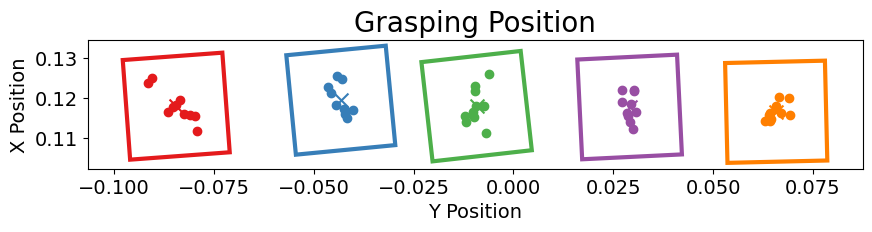

In [4]:

repo_id="nduque/robustness_e8_5"
repo_id="nduque/robustness_e8"

dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])
    episode = dataset.hf_dataset

    obs_set = observations[ep_start+30:ep_end]
    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)
obs_grasp = np.array(obs_grasp)

box_pos_avg_e8 = np.array([[ 0.1179,-0.0844, 4.2366],[ 0.1194, -0.0432, 5.4916],[ 0.1179, -0.0092, 6.4004],[ 0.1177, 0.0291, 2.7933],[ 0.1165, 0.0658, 1.3591]])
box_pos_avg_e8_5 = np.array([[0.1201, -0.076, 4.9085],[ 0.1199, -0.0373, 4.3924],[ 0.1198, -0.0012, 3.5846],[ 0.1211, 0.0374, 0.4634],[0.1217, 0.073, 0.0573]])

box_avg = box_pos_avg_e8

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    print([avg_x, avg_y, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_xy.append([ep_dx,ep_dy])

    fc = color
    axs.scatter(obs_grasp[i*eps:(i+1)*eps, 1], obs_grasp[i*eps:(i+1)*eps, 0],color=color, fc=fc)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    axs.add_patch(rec)

    #axs.text(box_pos_avg_e8[i,0],box_pos_avg_e8[i,1]-0.004,str(dist_to_avg),ha='center')
d_xy = np.array(d_xy)

axs.set_xlabel("Y Position", fontsize=14)
axs.set_ylabel("X Position", fontsize=14)
axs.set_title("Grasping Position", fontsize=20)
axs.set_aspect('equal')
#axs.set_ylim(0.08,0.15)
axs.tick_params(axis='both', which='major', labelsize=14)
#axs.set_xlim(-0.1,0.1)


### Evaluation plots ###

C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[0.1279, -0.0265, 4.1158]


[0.1278, -0.0135, 4.2024]


[0.1283, -0.0139, 3.9031]


[0.1288, -0.0184, 4.9077]


[0.1276, -0.0273, 4.665]


[0.127, -0.0144, 2.5423]


[0.1318, 0.0224, 3.7449]


[0.1265, -0.0383, 6.7132]
[0.1323, -0.0347, 4.3523]


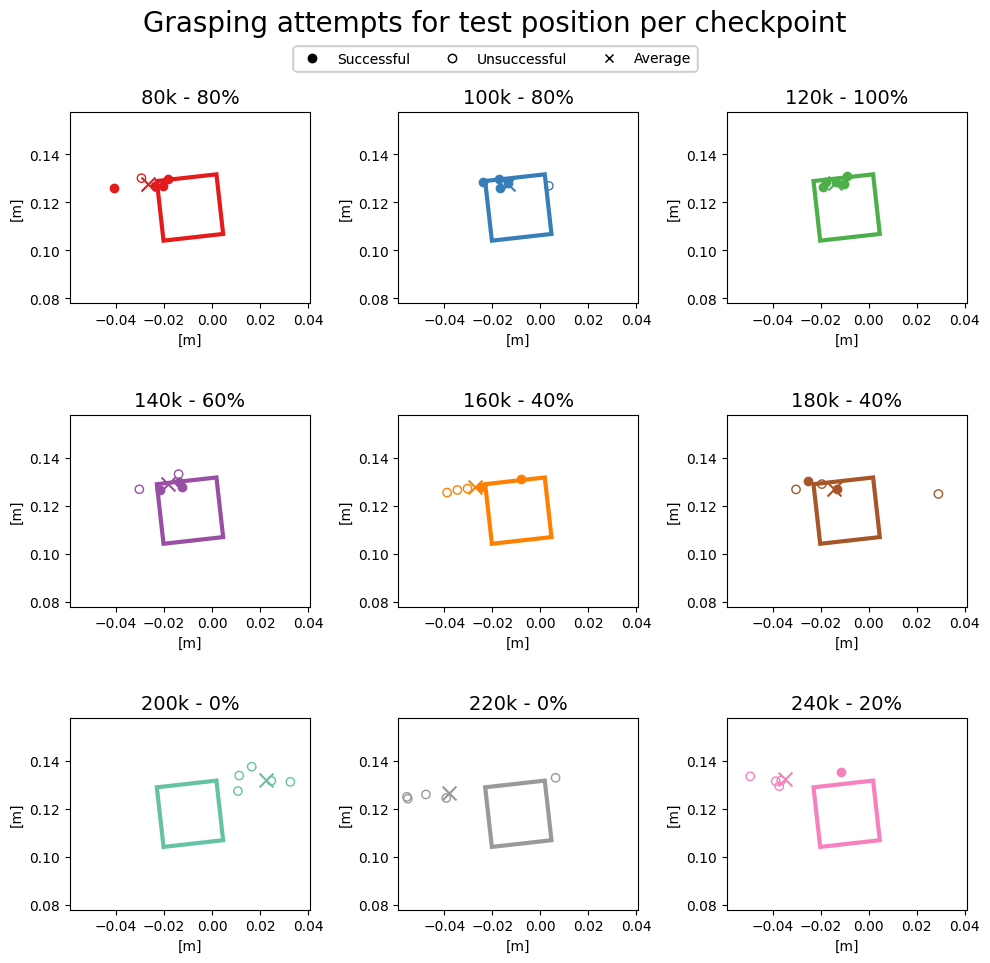

In [5]:
repos = ["nduque/eval_robustness_e8_no3_3_80k",
         "nduque/eval_robustness_e8_no3_3_100k_2",
         "nduque/eval_robustness_e8_no3_3_120k",
         "nduque/eval_robustness_e8_no3_3_140k",
         "nduque/eval_robustness_e8_no3_3_160k",
         "nduque/eval_robustness_e8_no3_3_180k",
         "nduque/eval_robustness_e8_no3_3_200k",
         "nduque/eval_robustness_e8_no3_3_220k",
         "nduque/eval_robustness_e8_no3_3_240k"]

success = [[1,1,1,1,0],
           [0,1,1,1,1],
           [1,1,1,1,1],
           [0,0,1,1,1],
           [1,0,0,0,1],
           [0,1,1,0,0],
           [0,0,0,0,0],
           [0,0,0,0,0],
           [1,0,0,0,0]]
titles = ["80k - 80%", "100k - 80%", "120k - 100%", "140k - 60%", "160k - 40%", "180k - 40%", "200k - 0%", "220k - 0%", "240k - 20%"]

avg_ep = []
fig, axs = plt.subplots(3,3, figsize=(10, 10))
d_xy = []
avg_err = []
total_grasp = []
for i,repo in enumerate(repos):
    

    dataset = LeRobotDataset(repo)
    observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
    episodes = list(range(dataset.meta.total_episodes))
    episode_data_index=get_episode_data_index(dataset.meta.episodes)
    eps_grasp = []
    eps_grasp_yaw = []

    box_avg = box_pos_avg_e8[2]
    eps = int(len(episodes)/len(box_avg))
    for j in range(len(episodes)):
        # Get the episode
        ep_start = int(episode_data_index["from"][episodes[j]])
        ep_end = int(episode_data_index["to"][episodes[j]])

        obs_set = observations[ep_start+30:ep_end]

        if len(obs_set) == 0:
            continue    
            
        grasp_idx = next((j for j, obs in enumerate(obs_set) if obs[-1] < 30), None)

        if grasp_idx is None:
            grasp_idx = next((j for j, obs in enumerate(obs_set) if obs[-1] < 40), None)

        fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
        eps_grasp.append(fk)
        eps_grasp_yaw.append(yaw)

    cp_grasp = np.array(eps_grasp)
    cp_grasp_yaw = np.array(eps_grasp_yaw)
    total_grasp.append(cp_grasp[:5])

    color = colors[i]

    avg_y = float(round(np.mean(cp_grasp[:, 1]),4))
    avg_x = float(round(np.mean(cp_grasp[:, 0]),4))
    avg_yaw = float(round(np.mean(cp_grasp_yaw[:]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    print([avg_x, avg_y, avg_yaw]) 

    ep_dx = cp_grasp[:, 0] - box_avg[0]
    ep_dy = cp_grasp[:, 1] - box_avg[1]
    d_norm = np.sqrt(ep_dx**2 + ep_dy**2)
    d_xy.append([ep_dx,ep_dy,d_norm])

    avg_err_x = np.mean((ep_dx))
    avg_err_y = np.mean((ep_dy))
    avg_err_norm = np.mean(d_norm)
    avg_err.append([avg_err_x, avg_err_y, avg_err_norm])


    for j in range(5):
        if success[i][j] == 0:
            fc = 'none'
        else:
            fc = color
        axs[i//3, i%3].scatter(cp_grasp[j,1], cp_grasp[j, 0],color=color, fc=fc)
 
    axs[i//3, i%3].scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_avg[1]-0.0125,box_avg[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_avg[2], rotation_point="center", linewidth=3)
    axs[i//3, i%3].add_patch(rec)
    axs[i//3, i%3].set_aspect('equal')
    axs[i//3, i%3].set_ylim(box_avg[0]-0.04,box_avg[0]+0.04)
    axs[i//3, i%3].set_xlim(box_avg[1]-0.05,box_avg[1]+0.05)
    axs[i//3, i%3].set_title(titles[i], fontsize=14)
    axs[i//3, i%3].set_xlabel('[m]', fontsize=10) 
    axs[i//3, i%3].set_ylabel('[m]', fontsize=10) 

    success_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Successful', fillstyle='full', linestyle='None')
    unsuccess_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Unsuccessful', fillstyle='none', linestyle='None')
    average_marker = mlines.Line2D([], [], color='black', marker='x', markersize=6, label='Average', fillstyle='none', linestyle='None')
    fig.legend(handles=[success_marker, unsuccess_marker,average_marker], loc='upper center', bbox_to_anchor=(0.5,0.95), fontsize=10, ncol=3)
    fig.suptitle("Grasping attempts for test position per checkpoint", fontsize=20)
    fig.tight_layout()



C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3278808443.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs2[idx].boxplot(boxplot_data, vert=True, labels=cps,positions = range(9))
C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3278808443.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs2[idx].boxplot(boxplot_data, vert=True, labels=cps,positions = range(9))


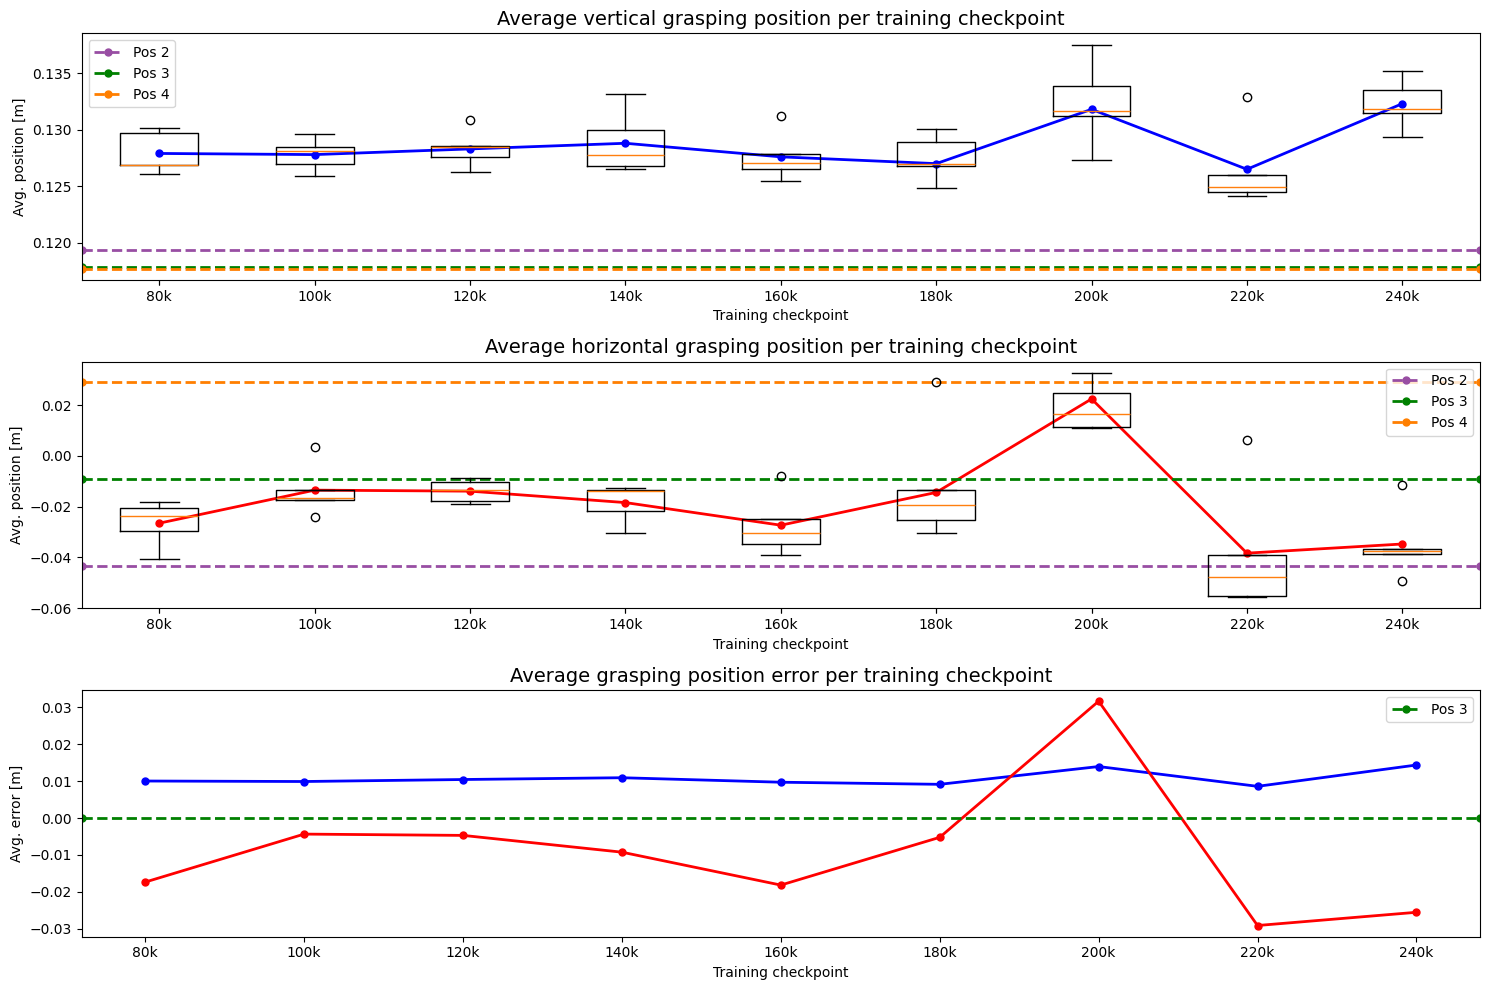

In [6]:
fig2, axs2 = plt.subplots(3, 1, figsize=(15, 10))
l_fs = 10
t_fs = 14

avg_ep = np.array(avg_ep)
avg_err = np.array(avg_err)
total_grasp = np.stack(total_grasp, axis=0)


cps = ['80k', '100k', '120k', '140k', '160k', '180k', '200k', '220k', '240k']

for idx, label in enumerate(['vertical', 'horizontal']):
    axs2[idx].plot(avg_ep[:, idx], color='blue' if idx == 0 else 'red', marker='o', linestyle='-', linewidth=2, markersize=5)
    axs2[idx].axhline(box_pos_avg_e8[1, idx], color=colors[3], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 2')
    axs2[idx].axhline(box_avg[idx], color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
    axs2[idx].axhline(box_pos_avg_e8[3, idx], color=colors[4], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 4')
    axs2[idx].set_xticks(range(9), cps, fontsize=l_fs)
    axs2[idx].set_xlabel('Training checkpoint', fontsize=l_fs)
    axs2[idx].set_ylabel('Avg. position [m]', fontsize=l_fs)
    axs2[idx].set_title(f'Average {label} grasping position per training checkpoint', fontsize=t_fs)
    axs2[idx].legend(fontsize=l_fs)
    boxplot_data = [arr[:,idx] for arr in total_grasp]
    axs2[idx].boxplot(boxplot_data, vert=True, labels=cps,positions = range(9))

axs2[2].plot(avg_err[:,0], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].plot(avg_err[:,1], color='red', marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].axhline(0.0, color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
axs2[2].set_xticks(range(9),cps, fontsize=l_fs)
axs2[2].set_xlabel('Training checkpoint', fontsize=l_fs)
axs2[2].set_ylabel('Avg. error [m]', fontsize=l_fs)
axs2[2].set_title('Average grasping position error per training checkpoint', fontsize=t_fs)
axs2[2].legend(fontsize=l_fs)


fig2.tight_layout()



Text(0.5, 1.0, 'Validation loss')

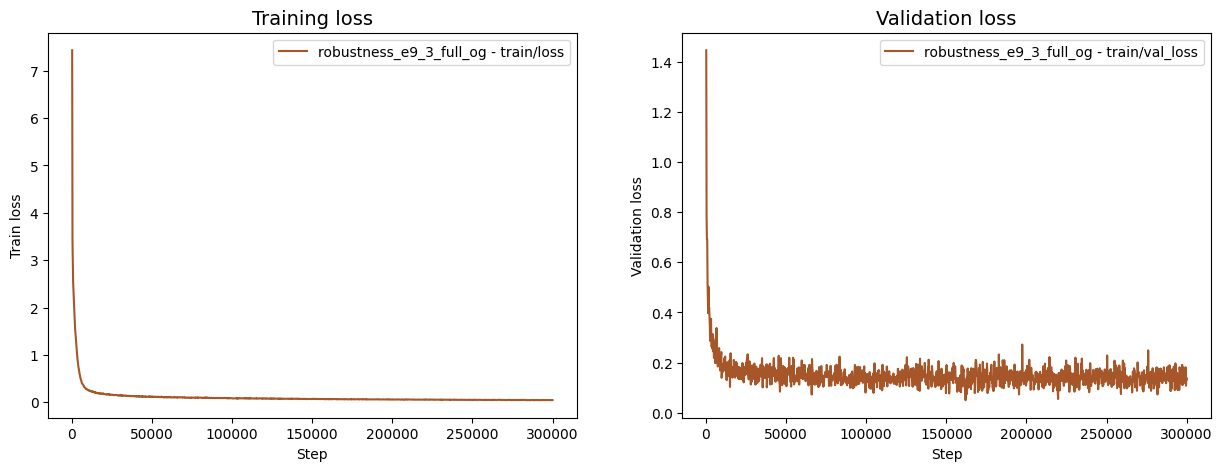

In [20]:
# Read the CSV file
csv_train = pd.read_csv('csv/e9_3_full_og_train_loss.csv')
csv_val = pd.read_csv('csv/e9_3_full_og_val_loss.csv')
fig3, axs3 = plt.subplots(1, 2, figsize=(15, 5))
# Plot the dataframe
csv_train.plot(ax=axs3[0],x='Step', y='robustness_e9_3_full_og - train/loss', color=colors[5])
csv_val.plot(ax=axs3[1],x='Step', y='robustness_e9_3_full_og - train/val_loss', color=colors[5])
axs3[0].set_ylabel('Train loss',fontsize=l_fs)
axs3[1].set_ylabel('Validation loss',fontsize=l_fs)
axs3[0].set_xlabel('Step', fontsize= l_fs)
axs3[1].set_xlabel('Step', fontsize=l_fs)
axs3[0].set_title('Training loss',fontsize=t_fs)
axs3[1].set_title('Validation loss',fontsize=t_fs)

## E9 Plots ##
### Dataset plot ###

C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[0.193, -0.0786, 5.8925]
[0.1898, -0.0009, 4.1929]
[0.1957, 0.0807, 1.2011]
[0.1533, -0.0393, 5.8473]
[0.1567, 0.0353, 1.4479]
[0.1211, -0.0746, 4.0604]
[0.1188, -0.0025, 3.8189]
[0.12, 0.0722, 0.7847]
[0.0861, -0.0396, 4.738]
[0.0868, 0.0366, -1.0705]
[0.0526, -0.0696, 4.0597]
[0.053, -0.0021, 1.3559]
[0.0554, 0.0694, -0.1613]


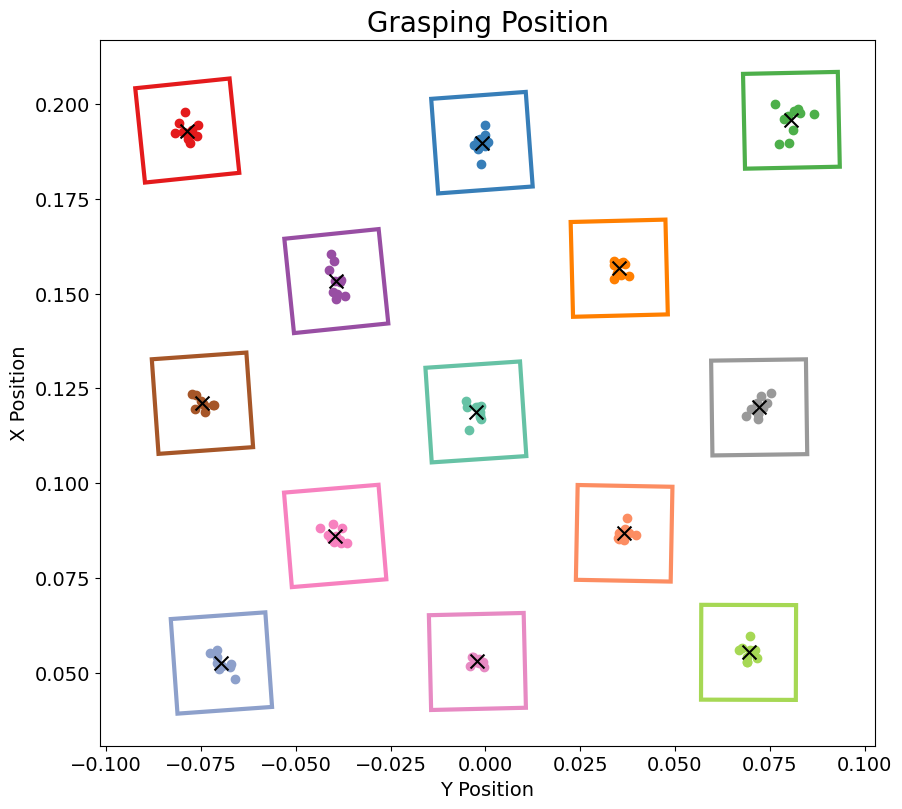

In [ ]:

repo_id="nduque/robustness_e9_3"

dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])
    episode = dataset.hf_dataset

    obs_set = observations[ep_start+30:ep_end]
    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)
obs_grasp = np.array(obs_grasp)

box_pos_avg_e9_3 = np.array([[0.193, -0.0786,  5.8925],[ 0.1898,-0.0009, 4.1929],[ 0.1957,0.0807, 1.2011],
                                 [ 0.1533,-0.0393, 5.8473],[ 0.1567,0.0353, 1.4479],[ 0.1211,-0.0746, 4.0604],
                                 [ 0.1188,-0.0025, 3.8189],[ 0.12,0.0722, 0.7847],[ 0.0861,-0.0396, 4.738],
                                 [ 0.0868,0.0366, -1.0705],[ 0.0526,-0.0696, 4.0597],[ 0.053,-0.0021, 1.3559],[ 0.0554,0.0694, -0.1613]])

box_avg = box_pos_avg_e9_3

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    print([avg_x, avg_y, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_xy.append([ep_dx,ep_dy])

    fc = color
    axs.scatter(obs_grasp[i*eps:(i+1)*eps, 1], obs_grasp[i*eps:(i+1)*eps, 0],color=color, fc=fc)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    axs.add_patch(rec)

    #axs.text(box_pos_avg_e8[i,0],box_pos_avg_e8[i,1]-0.004,str(dist_to_avg),ha='center')
d_xy = np.array(d_xy)

axs.set_xlabel("Y Position", fontsize=14)
axs.set_ylabel("X Position", fontsize=14)
axs.set_title("Grasping Position", fontsize=20)
axs.set_aspect('equal')
#axs.set_ylim(0.08,0.15)
axs.tick_params(axis='both', which='major', labelsize=14)
#axs.set_xlim(-0.1,0.1)

### Evaluation plots ###
#### Grasping plot + success rate heatmap full_dp_cluster_200k ####


C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_27536\3266642409.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[-0.0798, 0.1963, 5.9146]
[-0.0586, 0.1925, 6.9202]
[-0.0042, 0.1945, 5.4101]
[0.0296, 0.1888, 3.6087]
[0.0812, 0.201, -0.1424]
[-0.0559, 0.1625, 4.318]
[-0.0421, 0.1603, 5.6004]
[-0.005, 0.1573, 3.4439]
[0.0379, 0.1588, 1.4378]
[0.0733, 0.1667, 2.3122]
[-0.0767, 0.1175, 4.1403]
[-0.0468, 0.1335, 5.6185]
[-0.0011, 0.1179, 3.4011]
[0.0481, 0.1304, 0.7462]
[0.0748, 0.122, 1.8146]
[-0.073, 0.0828, 2.4471]
[-0.0425, 0.0927, 3.8642]
[0.0001, 0.0844, 2.5302]
[0.0353, 0.0865, -2.2026]
[0.0661, 0.093, 2.229]
[-0.0674, 0.0499, 5.1111]
[-0.0254, 0.0698, 3.1592]
[-0.002, 0.0509, 0.1441]
[0.0306, 0.0755, -4.9286]
[0.0704, 0.0582, -0.0116]


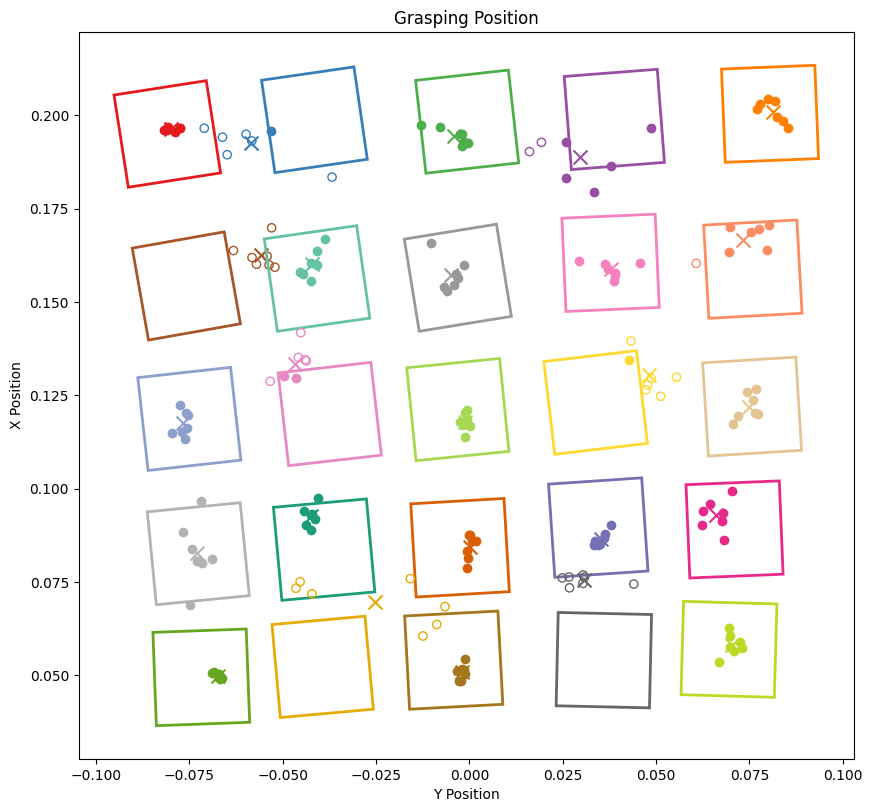

In [36]:
repo_id="nduque/eval_robustness_e9_3_full_dp_cluster_200k"
box_pos_avg_e9_all = [[0.195,-0.0809,  8.8293],[0.1988,-0.0415,  8.2231],[ 0.1983,-0.0006, 6.3474],[ 0.1989, 0.0388, 4.407],[ 0.2004,0.0805, 2.3005],
                   [ 0.1543,-0.0758, 10.03],[ 0.1563,-0.0408, 8.1177],[ 0.1565,-0.0031, 9.1966],[ 0.1605,0.0378, 2.4887],[ 0.1588, 0.0759,3.1575],
                   [ 0.1187,-0.075, 6.3325],[ 0.12,-0.0374, 6.469],[ 0.1212,-0.0031, 5.7372],[ 0.1231,0.0338, 6.6873],[ 0.122,0.0757, 3.5465],
                   [ 0.0826,-0.0726, 5.5792],[ 0.0837,-0.0389, 5.1754],[ 0.0842,-0.0025, 3.2955],[ 0.0896,0.0345, 3.8578],[ 0.0891,0.071, 2.3324],
                   [ 0.0495,-0.0718, 2.1085],[ 0.0523,-0.0393, 5.1431],[0.0541,-0.0042,  3.0332],[ 0.0541,0.036, -1.2648],[ 0.057,0.0695, -1.611]]

success_e9_3_full_dp_cluster_200k = np.array([1,1,1,1,1,1,1, #1
                                                0,0,0,0,0,0,1, #2
                                                1,1,1,1,1,1,1, #3
                                                1,1,0,1,1,1,0, #4
                                                1,1,1,1,1,1,1, #5
                                                0,0,0,0,0,0,0, #6
                                                1,1,1,1,1,1,1, #7
                                                1,1,1,1,1,1,1, #8
                                                1,1,1,1,1,1,1, #9
                                                1,0,1,1,1,1,1, #10
                                                1,1,1,1,1,1,1, #11
                                                1,0,0,1,0,0,0, #12 
                                                1,1,1,1,1,1,1, #13 
                                                0,0,0,0,0,0,1, #14
                                                1,1,1,1,1,1,1, #15
                                                1,1,1,1,1,1,1, #16
                                                1,1,1,1,1,1,1, #17
                                                1,1,1,1,1,1,1, #18
                                                1,1,1,1,1,1,1, #19
                                                1,1,1,1,1,1,1, #20
                                                1,1,1,1,1,1,1, #21
                                                0,0,0,0,0,0,0, #22
                                                1,1,1,1,1,1,1, #23
                                                0,0,0,0,0,0,0, #24
                                                1,1,1,1,1,1,1  #25
                                                ]) 
dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])

    obs_set = observations[ep_start+30:ep_end]

    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)


obs_grasp = np.array(obs_grasp)


fig, axs = plt.subplots(1, 1, figsize=(10, 15))

box_pos_avg_e9_all = np.array(box_pos_avg_e9_all)
box_avg = box_pos_avg_e9_all
eps = int(len(episodes)/len(box_avg))

success = success_e9_3_full_dp_cluster_200k
eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []

for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
    
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_y, avg_x, avg_yaw])
    print([avg_y, avg_x, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_xy.append([ep_dx,ep_dy])


    fc = color
    for j in range(eps):
            if success[i*eps+j] == 0:
                fc = 'none'
            else:
                fc = color
            axs.scatter(obs_grasp[i*eps+j,1], obs_grasp[i*eps+j, 0],color=color, fc=fc)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=2)
    axs.add_patch(rec)


d_xy = np.array(d_xy)

axs.set_xlabel("Y Position")
axs.set_ylabel("X Position")
axs.set_title("Grasping Position")
axs.set_aspect('equal')
#axs.set_ylim(0.04,0.22)
#axs.set_xlim(-0.1,0.1)